# Memory

This notebook demonstrates the simplest(trivial) form of computation: logical memory. More specifically, a logical qubit with distance $d$ remains idle for $d$ error correction cycles [<cite data-footcite-t="Acharya_2024"></cite>].

## Construction

A memory experiment can be represented with a single cube. The color of the cube determines the spatial/temporal boundary types.

`tqec` provides builtin functions `tqec.gallery.memory` to construct it.

In [1]:
from tqec import Basis
from tqec.gallery import memory

graph = memory(Basis.Z)
graph.view_as_html()

Memory experiment preserves the logical observable through time:

In [2]:
correlation_surfaces = graph.find_correlation_surfaces()
graph.view_as_html(
    pop_faces_at_direction="-Y",
    show_correlation_surface=correlation_surfaces[0],
)

## Circuit

You can download the circuit for a $d=3$ logical Z memory experiment from [here](../media/gallery/memory/circuit.stim), or generate it with the code below. You can also open the circuit in [Crumble](https://algassert.com/crumble#circuit=Q(0,4)0;Q(1,1)1;Q(1,3)2;Q(1,5)3;Q(2,0)4;Q(2,2)5;Q(2,4)6;Q(3,1)7;Q(3,3)8;Q(3,5)9;Q(4,2)10;Q(4,4)11;Q(4,6)12;Q(5,1)13;Q(5,3)14;Q(5,5)15;Q(6,2)16;R_1_2_3_7_8_9_13_14_15;RX_0_4_5_6_10_11_12_16;POLYGON(0,0,1,0.25)1_7_8_2;POLYGON(0,0,1,0.25)13_14;POLYGON(0,0,1,0.25)2_3;POLYGON(0,0,1,0.25)8_14_15_9;POLYGON(1,0,0,0.25)7_1;POLYGON(1,0,0,0.25)7_13_14_8;POLYGON(1,0,0,0.25)2_8_9_3;POLYGON(1,0,0,0.25)15_9;TICK;CX_6_2_10_7_12_9;CZ_5_1_11_8_16_13;TICK;CX_6_8_10_13_12_15;CZ_0_2;TICK;CX_4_1_6_3_10_8;CZ_5_2_11_9_16_14;TICK;CZ_5_7_11_14;TICK;CX_4_7_6_9_10_14;CZ_0_3_5_8_11_15;TICK;MX_0_4_5_6_10_11_12_16;DT(0,4,0)rec[-8];DT(2,2,0)rec[-6];DT(4,4,0)rec[-3];DT(6,2,0)rec[-1];TICK;RX_0_4_5_6_10_11_12_16;TICK;CX_6_2_10_7_12_9;CZ_5_1_11_8_16_13;TICK;CX_6_8_10_13_12_15;CZ_0_2;TICK;CX_4_1_6_3_10_8;CZ_5_2_11_9_16_14;TICK;CZ_5_7_11_14;TICK;CX_4_7_6_9_10_14;CZ_0_3_5_8_11_15;TICK;MX_0_4_5_6_10_11_12_16;DT(0,4,1)rec[-8]_rec[-16];DT(2,0,1)rec[-7]_rec[-15];DT(2,2,1)rec[-6]_rec[-14];DT(2,4,1)rec[-5]_rec[-13];DT(4,2,1)rec[-4]_rec[-12];DT(4,4,1)rec[-3]_rec[-11];DT(4,6,1)rec[-2]_rec[-10];DT(6,2,1)rec[-1]_rec[-9];TICK;RX_0_4_5_6_10_11_12_16;TICK;CX_6_2_10_7_12_9;CZ_5_1_11_8_16_13;TICK;CX_6_8_10_13_12_15;CZ_0_2;TICK;CX_4_1_6_3_10_8;CZ_5_2_11_9_16_14;TICK;CZ_5_7_11_14;TICK;CX_4_7_6_9_10_14;CZ_0_3_5_8_11_15;TICK;M_1_2_3_7_8_9_13_14_15;MX_0_4_5_6_10_11_12_16;DT(1,3,2)rec[-8]_rec[-15]_rec[-16];DT(0,4,2)rec[-8]_rec[-25];DT(2,0,2)rec[-7]_rec[-24];DT(2,2,2)rec[-6]_rec[-13]_rec[-14]_rec[-16]_rec[-17];DT(2,2,3)rec[-6]_rec[-23];DT(2,4,2)rec[-5]_rec[-22];DT(4,2,2)rec[-4]_rec[-21];DT(4,4,2)rec[-3]_rec[-9]_rec[-10]_rec[-12]_rec[-13];DT(4,4,3)rec[-3]_rec[-20];DT(4,6,2)rec[-2]_rec[-19];DT(5,3,2)rec[-1]_rec[-10]_rec[-11];DT(6,2,2)rec[-1]_rec[-18];OI(0)rec[-10]_rec[-13]_rec[-16]).

.. note::
    Note that the syndrome extraction circuits used here are of depth-7 because we use an extra layer of two-qubit gates to align with the potential spatial cubes. The depth can be reduced to 6 with some post-processing on the circuit.

In [3]:
from tqec import NoiseModel, compile_block_graph

compiled_graph = compile_block_graph(graph)
circuit = compiled_graph.generate_stim_circuit(
    k=1, noise_model=NoiseModel.uniform_depolarizing(p=0.001)
)

## Simulation

Here we show the simulation results of both Z-basis and X-basis memory experiments under **uniform depolarizing** noise mode.

<details><summary><strong>Click to show the full code used for simulation</strong></summary>

```py
from pathlib import Path

import matplotlib.pyplot as plt
import numpy
import sinter

from tqec.gallery.memory import memory
from tqec import NoiseModel
from tqec.simulation.plotting.inset import plot_observable_as_inset
from tqec.simulation.simulation import start_simulation_using_sinter
from tqec.utils.enums import Basis

SAVE_DIR = Path("results")


def generate_graphs(support_observable_basis: Basis) -> None:
    block_graph = memory(support_observable_basis)
    zx_graph = block_graph.to_zx_graph()

    correlation_surfaces = block_graph.find_correlation_surfaces()

    stats = start_simulation_using_sinter(
        block_graph,
        range(1, 4),
        list(numpy.logspace(-4, -1, 10)),
        NoiseModel.uniform_depolarizing,
        manhattan_radius=2,
        observables=correlation_surfaces,
        num_workers=20,
        max_shots=10_000_000,
        max_errors=5_000,
        decoders=["pymatching"],
        print_progress=True,
    )

    for i, stat in enumerate(stats):
        fig, ax = plt.subplots()
        sinter.plot_error_rate(
            ax=ax,
            stats=stat,
            x_func=lambda stat: stat.json_metadata["p"],
            failure_units_per_shot_func=lambda stat: stat.json_metadata["d"],
            group_func=lambda stat: stat.json_metadata["d"],
        )
        plot_observable_as_inset(ax, zx_graph, correlation_surfaces[i])
        ax.grid(axis="both")
        ax.legend()
        ax.loglog()
        ax.set_title("Logical Memory Error Rate")
        ax.set_xlabel("Physical Error Rate")
        ax.set_ylabel("Logical Error Rate(per round)")
        fig.savefig(
            SAVE_DIR
            / f"logical_memory_result_{support_observable_basis}_observable_{i}.png"
        )


def main():
    SAVE_DIR.mkdir(exist_ok=True)
    generate_graphs(Basis.Z)
    generate_graphs(Basis.X)


if __name__ == "__main__":
    main()

```

</details>

In [4]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy
import sinter

from tqec import NoiseModel
from tqec.gallery.memory import memory
from tqec.simulation.plotting.inset import plot_observable_as_inset
from tqec.simulation.simulation import start_simulation_using_sinter
from tqec.utils.enums import Basis


def generate_graphs(support_observable_basis: Basis) -> None:
    block_graph = memory(support_observable_basis)
    zx_graph = block_graph.to_zx_graph()

    correlation_surfaces = block_graph.find_correlation_surfaces()

    stats = start_simulation_using_sinter(
        block_graph,
        range(1, 4),
        list(numpy.logspace(-4, -1, 10)),
        NoiseModel.uniform_depolarizing,
        manhattan_radius=2,
        observables=correlation_surfaces,
        num_workers=20,
        max_shots=10_000_000,
        max_errors=5_000,
        decoders=["pymatching"],
        save_resume_filepath=Path("../_examples_database/memory_stats"),
        database_path=Path("../_examples_database/memory_database"),
    )

    for i, stat in enumerate(stats):
        fig, ax = plt.subplots()
        sinter.plot_error_rate(
            ax=ax,
            stats=stat,
            x_func=lambda stat: stat.json_metadata["p"],
            failure_units_per_shot_func=lambda stat: stat.json_metadata["d"],
            group_func=lambda stat: stat.json_metadata["d"],
        )
        plot_observable_as_inset(ax, zx_graph, correlation_surfaces[i])
        ax.grid(axis="both")
        ax.legend()
        ax.loglog()
        ax.set_title("Logical Memory Error Rate")
        ax.set_xlabel("Physical Error Rate")
        ax.set_ylabel("Logical Error Rate(per round)")

### Z Basis

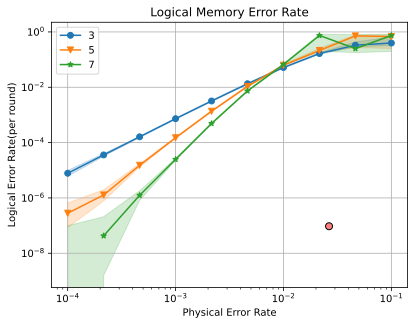

In [5]:
generate_graphs(Basis.Z)

### X Basis

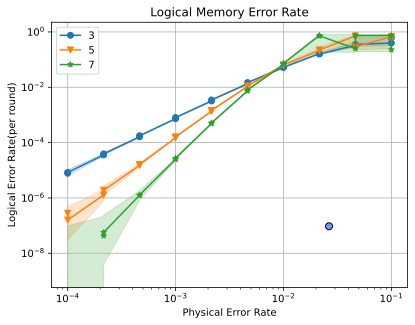

In [6]:
generate_graphs(Basis.X)

## References

.. footbibliography::